# NAS with image classifier on Cifar10

Import the required libraries

In [14]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import torch
import autokeras as ak
import numpy as np
#from tensorflow.keras.datasets import mnist
import tensorflow_datasets as tfds
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#### Loading data
Here we loads the CIFAR-10 dataset using the TensorFlow Keras API. 

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
print(x_train.shape)
print(x_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


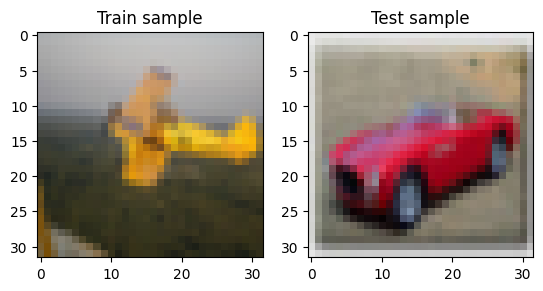

In [3]:
%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
plt.imshow(x_train[1234])
ax.set_title('Train sample')
ax = fig.add_subplot(1, 2, 2)
plt.imshow(x_test[1234])
ax.set_title('Test sample')
plt.show()


#### How the digits are distributed?
When we are working with data sets, it is very important to check that the data is distributed homogeneously, this can be done easily using numpy functions.

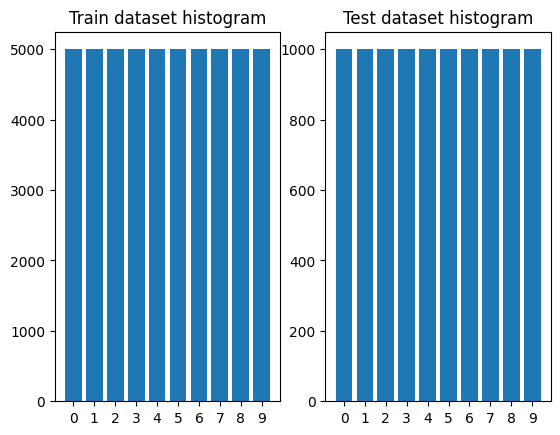

In [4]:
train_histogram = np.histogram(y_train)
test_histogram = np.histogram(y_test)
_, axs = plt.subplots(1, 2)
axs[0].set_xticks(range(10))
axs[0].bar(range(10), train_histogram[0])
axs[0].set_title('Train dataset histogram')
axs[1].set_xticks(range(10))
axs[1].bar(range(10), test_histogram[0])
axs[1].set_title('Test dataset histogram')
plt.show()

#### Creating an image classifier
Now, we will use the AutoKeras ImageClassifier to find the best classification model. We set max_trials (the maximum number of different Keras Models to try) to 1 and the number of epochs to train each model to 10, but for real use it is recommended to set a large number of trials and not to set the epochs parameter to use an adaptive number of epochs automatically.

In [5]:
# Initialize the image classifier.
clf = ak.ImageClassifier(overwrite=True, max_trials=1)


In [6]:
# Feed the image classifier with training data.
clf.fit(x_train, y_train, epochs=10)

Trial 1 Complete [00h 08m 44s]
val_loss: 0.8901848196983337

Best val_loss So Far: 0.8901848196983337
Total elapsed time: 00h 08m 44s
INFO:tensorflow:Oracle triggered exit
Epoch 1/10
1563/1563 [==============================] - 52s 33ms/step - loss: 1.3443 - accuracy: 0.5258
Epoch 2/10
1563/1563 [==============================] - 50s 32ms/step - loss: 1.0601 - accuracy: 0.6312
Epoch 3/10
1563/1563 [==============================] - 52s 33ms/step - loss: 0.9764 - accuracy: 0.6592
Epoch 4/10
1563/1563 [==============================] - 50s 32ms/step - loss: 0.9193 - accuracy: 0.6800
Epoch 5/10
1563/1563 [==============================] - 49s 31ms/step - loss: 0.8793 - accuracy: 0.6953
Epoch 6/10
1563/1563 [==============================] - 49s 32ms/step - loss: 0.8435 - accuracy: 0.7072
Epoch 7/10
1563/1563 [==============================] - 49s 31ms/step - loss: 0.8171 - accuracy: 0.7136
Epoch 8/10
1563/1563 [==============================] - 49s 31ms/step - loss: 0.7954 - accuracy: 0.7

INFO:tensorflow:Assets written to: ./image_classifier/best_model/assets


INFO:tensorflow:Assets written to: ./image_classifier/best_model/assets


#### Evaluating the model with the test set
After training it's time to measure the real prediction of our model using the reserved test dataset

In [7]:
metrics = clf.evaluate(x_test, y_test)
print(metrics)

313/313 [==============================] - 2s 6ms/step - loss: 0.8345 - accuracy: 0.7112
[0.8344833850860596, 0.7111999988555908]


Lets see how is predicting this single sample

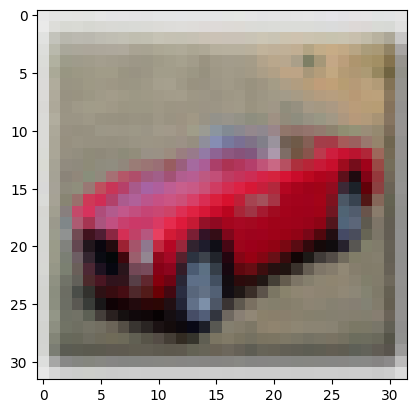

In [8]:
fig = plt.figure()
plt.imshow(x_test[1234])
ax.set_title('Test sample')
plt.show()

In [9]:
# Predict with the best model.
predicted_y = clf.predict(x_test)
print(predicted_y)


313/313 [==============================] - 2s 6ms/step
[['3']
 ['1']
 ['8']
 ...
 ['3']
 ['1']
 ['7']]


#### Visualizing the classifier model

In [10]:
# Export as a Keras Model.
model = clf.export_model()
#print(model)
print(type(model))  
model.summary()

<class 'keras.engine.functional.Functional'>
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 cast_to_float32 (CastToFloa  (None, 32, 32, 3)        0         
 t32)                                                            
                                                                 
 normalization (Normalizatio  (None, 32, 32, 3)        7         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (

## Customized Search Space
Here use AutoKeras (ak) to create an Image Classification model with a customized search space. setting the block_type argument to "resnet" specifies that only ResNet architectures will be considered during the architecture search process.After that A ClassificationHead is added to the output node to perform the classification task.


In [20]:
input_node = ak.ImageInput()
output_node = ak.ImageBlock(
    # Only search ResNet architectures.
    block_type="resnet",
    # Normalize the dataset.
    normalize=True,
    # Do not do data augmentation.
    augment=False,
)(input_node)
output_node = ak.ClassificationHead()(output_node)


AutoKeras will search for the best model architecture and hyperparameters based on the training data provided.


In [14]:
clf = ak.AutoModel(
    inputs=input_node, outputs=output_node, overwrite=True, max_trials=1
)

In [15]:
clf.fit(x_train, y_train, epochs=10)

Trial 1 Complete [03h 56m 26s]
val_loss: 1.4962941408157349

Best val_loss So Far: 1.4962941408157349
Total elapsed time: 03h 56m 26s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Epoch 1/10
1563/1563 [==============================] - 1769s 1s/step - loss: 2.1561 - accuracy: 0.3380
Epoch 2/10
1563/1563 [==============================] - 1714s 1s/step - loss: 1.9457 - accuracy: 0.3967
Epoch 3/10
1563/1563 [==============================] - 1740s 1s/step - loss: 1.7958 - accuracy: 0.4298
Epoch 4/10
1563/1563 [==============================] - 1748s 1s/step - loss: 1.7334 - accuracy: 0.4651
Epoch 5/10
1563/1563 [==============================] - 1733s 1s/step - loss: 1.8305 - accuracy: 0.4268
Epoch 6/10
1563/1563 [==============================] - 1727s 1s/step - loss: 1.6151 - accuracy: 0.4833
Epoch 7/10
1563/1563 [==============================] - 1730s 1s/step - loss: 1.3492 - accuracy: 0.5525
Epoch 8/10
1563/1563 [==============================] - 1728s 1s/step - loss: 1.2945 - accuracy: 0.5692
Epoch 9/10
1563/1563 [==============================] - 1727s 1s/step - loss: 1.1897 - accuracy: 0.6020
Epoch 10/10
1563/1563 [==============================] - 1727s 1

INFO:tensorflow:Assets written to: ./auto_model/best_model/assets


INFO:tensorflow:Assets written to: ./auto_model/best_model/assets


#### Evaluating the model with the test set
After training it's time to measure the real prediction of our model using the reserved test dataset

In [16]:
metrics = clf.evaluate(x_test, y_test)
print(metrics)

313/313 [==============================] - 13s 39ms/step - loss: 1.6686 - accuracy: 0.5213
[1.6685718297958374, 0.5213000178337097]


#### Visualizing the Model

In [17]:
# Export as a Keras Model.
model = clf.export_model()
#print(model)
print(type(model)) 
model.summary()

<class 'keras.engine.functional.Functional'>
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 cast_to_float32 (CastToFloa  (None, 32, 32, 3)        0         
 t32)                                                            
                                                                 
 normalization (Normalizatio  (None, 32, 32, 3)        7         
 n)                                                              
                                                                 
 resnet50 (Functional)       (None, 1, 1, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)  

### Customized Search Space with ResNetV2

Here by using AutoKeras to create an Image Classification model, but with a slightly different custom search space like The ResNetBlock layer is added to the output node. In this case, the version argument is set to "v2", which specifies the version of the ResNet architecture to use.


In [40]:
input_node = ak.ImageInput()
output_node = ak.Normalization()(input_node)
output_node = ak.ImageAugmentation(horizontal_flip=False)(output_node)
output_node = ak.ResNetBlock(version="v2")(output_node)
output_node = ak.ClassificationHead()(output_node)

An AutoModel is created using the input and output nodes. The overwrite argument is set to True, which means that if there is an existing model with the same name, it will be overwritten. The max_trials argument is set to 1, which means that AutoKeras will run 1 trials to find the best model architecture.

In [41]:
clf = ak.AutoModel(
    inputs=input_node, outputs=output_node, overwrite=True, max_trials=1
)

In [42]:
clf.fit(x_train, y_train, epochs=10)

Trial 1 Complete [03h 47m 07s]
val_loss: 2.1997909545898438

Best val_loss So Far: 2.1997909545898438
Total elapsed time: 03h 47m 07s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Epoch 1/10
1563/1563 [==============================] - 1699s 1s/step - loss: 1.8575 - accuracy: 0.3663
Epoch 2/10
1563/1563 [==============================] - 1691s 1s/step - loss: 1.6517 - accuracy: 0.4285
Epoch 3/10
1563/1563 [==============================] - 1691s 1s/step - loss: 1.5626 - accuracy: 0.4572
Epoch 4/10
1563/1563 [==============================] - 1689s 1s/step - loss: 1.3075 - accuracy: 0.5442
Epoch 5/10
1563/1563 [==============================] - 1689s 1s/step - loss: 1.0928 - accuracy: 0.6197
Epoch 6/10
1563/1563 [==============================] - 1689s 1s/step - loss: 0.9580 - accuracy: 0.6701
Epoch 7/10
1563/1563 [==============================] - 1690s 1s/step - loss: 0.8639 - accuracy: 0.7027
Epoch 8/10
1563/1563 [==============================] - 1692s 1s/step - loss: 0.7547 - accuracy: 0.7417
Epoch 9/10
1563/1563 [==============================] - 1695s 1s/step - loss: 0.6227 - accuracy: 0.7862
Epoch 10/10
1563/1563 [==============================] - 1723s 1

INFO:tensorflow:Assets written to: ./auto_model/best_model/assets


INFO:tensorflow:Assets written to: ./auto_model/best_model/assets


# Auto model
Here use AutoKeras to build an image classification model for the CIFAR-10 dataset

In [5]:
import autokeras as ak
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
# Load the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
# Convert labels to categorical format
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

Define an AutoModel using the AutoKeras API. The model consists of an image input, an image block, a flatten layer, a dense block, and a classification head.

In [6]:
# Define the AutoModel
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
input_node = ak.ImageInput()
output_node = ak.ImageBlock()(input_node)
output_node = ak.Flatten()(output_node)
output_node = ak.DenseBlock()(output_node)
output_node = ak.ClassificationHead()(output_node)

The max_trials parameter of the AutoModel constructor is set to 2, which means that AutoKeras will try two different model architectures before returning the best one. 

In [7]:
# Initialize the AutoModel
clfs = ak.AutoModel(
    inputs=input_node,
    outputs=output_node,
    overwrite=True,
    max_trials=2
)

In [8]:
# Fit the AutoModel to the CIFAR-10 dataset
print(device)
clfs.fit(x_train, y_train, epochs=2)

Trial 2 Complete [01h 13m 41s]
val_loss: 2.302663564682007

Best val_loss So Far: 2.1938133239746094
Total elapsed time: 02h 34m 25s
INFO:tensorflow:Oracle triggered exit
Epoch 1/2
1563/1563 [==============================] - 2865s 2s/step - loss: 1.8354 - accuracy: 0.3064
Epoch 2/2
1563/1563 [==============================] - 2949s 2s/step - loss: 1.5612 - accuracy: 0.4198


INFO:tensorflow:Assets written to: ./auto_model/best_model/assets


INFO:tensorflow:Assets written to: ./auto_model/best_model/assets


In [9]:

# Evaluate the AutoModel on the test data
accuracy = clf.evaluate(x_test, y_test)[1]
print('Accuracy: {:.2f}%'.format(accuracy * 100))

313/313 [==============================] - 26s 77ms/step - loss: 1.6277 - accuracy: 0.4257
Accuracy: 42.57%


In [10]:
# Export as a Keras Model.
model = clf.export_model()
#print(model)
print(type(model))  
model.summary()

<class 'keras.engine.functional.Functional'>
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 cast_to_float32 (CastToFloa  (None, 32, 32, 3)        0         
 t32)                                                            
                                                                 
 resnet50 (Functional)       (None, 1, 1, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 32)                65568     
                                                                 
 re_lu (ReLU)                (None, 32)                0         
                